<a href="https://colab.research.google.com/github/stiwari-ds/DL-Simplified-SWOC-S3/blob/dance-form-clf/Dance-Form-Classification/Model/01_cnn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import subprocess
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
SEED = 2311
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#Check GPU availability
try:
    subprocess.check_output('nvidia-smi')
    HAVE_GPU = True
except Exception:
    HAVE_GPU = False

print(f'GPU available: {HAVE_GPU}')

GPU available: True


# Data

In [ ]:
%%capture
if not os.path.isdir('/content/train'):
    # runs fine despite syntax warning
    !wget https://storage.googleapis.com/dance-forms-dataset/dance_forms.zip
    !unzip dance_forms.zip

In [ ]:
train_df = pd.read_csv('train.csv', dtype='string') # filename->label mapping
image_dir = '/content/train/' # images directory

# Basic EDA and Data preparation

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   364 non-null    string
 1   target  364 non-null    string
dtypes: string(2)
memory usage: 5.8 KB


In [ ]:
train_df.sample()

,Image,target
351,66.jpg,kathak


In [ ]:
train_df['Image'] = train_df.Image.apply(lambda x: image_dir + x)

In [ ]:
train_df.sample()

,Image,target
281,/content/train/257.jpg,mohiniyattam


In [ ]:
train_df.target.value_counts(normalize=True)

mohiniyattam     0.137363
odissi           0.134615
bharatanatyam    0.129121
kathakali        0.129121
kuchipudi        0.126374
sattriya         0.123626
kathak           0.120879
manipuri         0.098901
Name: target, dtype: Float64

Fairly balanced.

**Creating a custom test dataset:**  

Test dataset provided in the source dataset does not have labels, which makes it useless for model evaluation. We can separate out some data in advance to test the performance of our model on unseen data.  
* There are 364 images in the dataset, with 8 classes.  
We will sample 8 images per class and create a test dataset. This will leave us with 300 training images and 64 test images.  
* The 300 training images will be used for training + validation.  
* The 64 test images will be untouched until final evaluation of the trained model.

Sampling rows for test dataset based on target classes:

In [ ]:
test_df = train_df.groupby('target', group_keys=False).apply(lambda x: x.sample(8, random_state=SEED))

In [ ]:
test_df.target.value_counts()

bharatanatyam    8
kathak           8
kathakali        8
kuchipudi        8
manipuri         8
mohiniyattam     8
odissi           8
sattriya         8
Name: target, dtype: Int64

Removing test rows from train_df:

In [ ]:
drop_condition = train_df['Image'].isin(test_df['Image'])
train_df.drop(train_df[drop_condition].index, inplace=True)

In [ ]:
train_df.shape, test_df.shape

((300, 2), (64, 2))

In [ ]:
set(train_df.Image).intersection(set(test_df.Image)) #no overlap

set()

**Saving processed datasets:**

In [ ]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

**Visualizing some images:**

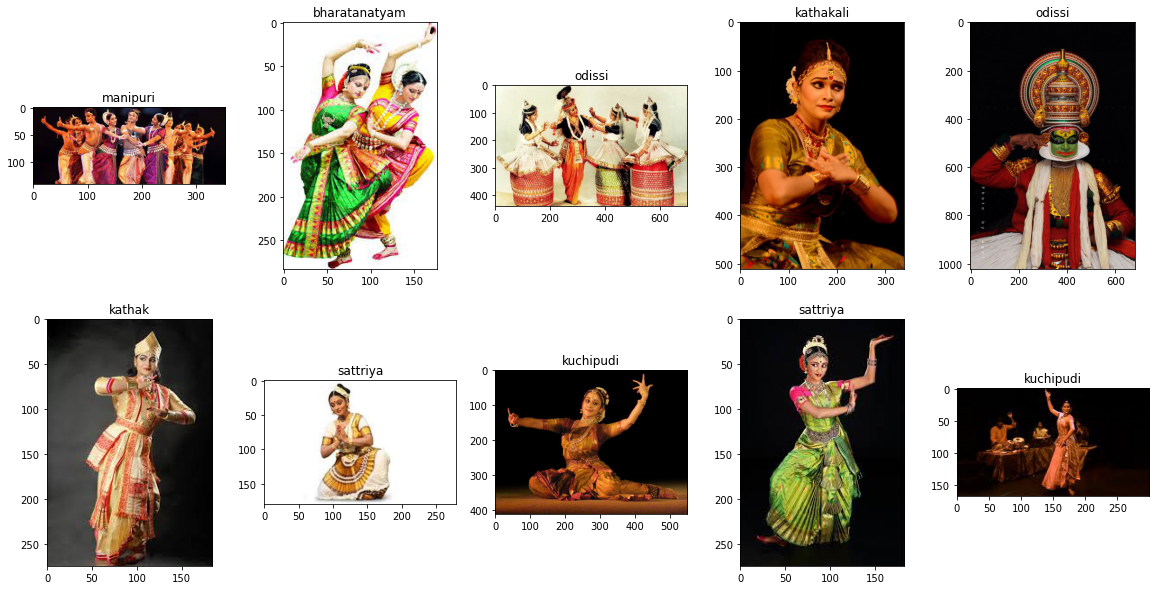

In [ ]:
train_imgs = os.listdir(image_dir)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
k = 0
for i in range(2):
    for j in range(5):    
        img = mpimg.imread(os.path.join(image_dir, train_imgs[k]))        
        ax[i][j].imshow(img, cmap=plt.get_cmap('gray'))
        ax[i][j].set_title(train_df.loc[k, 'target'])
        k += 1

In [ ]:
img = mpimg.imread(os.path.join(image_dir, train_imgs[0]))

In [ ]:
img

array([[[ 8,  8,  8],
        [ 9,  7,  8],
        [ 9,  7,  8],
        ...,
        [13,  7,  9],
        [13,  7,  9],
        [13,  7,  9]],

       [[ 9,  7,  8],
        [ 9,  7,  8],
        [ 9,  7,  8],
        ...,
        [13,  7,  9],
        [13,  7,  9],
        [13,  7,  9]],

       [[ 9,  7,  8],
        [ 9,  7,  8],
        [ 9,  7,  8],
        ...,
        [13,  7,  9],
        [13,  7,  9],
        [13,  7,  9]],

       ...,

       [[ 6,  1,  0],
        [ 5,  0,  0],
        [ 5,  0,  0],
        ...,
        [ 2,  1,  7],
        [ 2,  1,  7],
        [ 3,  2,  8]],

       [[16,  5,  1],
        [16,  5,  1],
        [15,  4,  0],
        ...,
        [ 2,  1,  7],
        [ 2,  1,  7],
        [ 3,  2,  8]],

       [[30, 15, 10],
        [29, 14,  9],
        [28, 13,  8],
        ...,
        [ 2,  1,  7],
        [ 2,  1,  7],
        [ 3,  2,  8]]], dtype=uint8)

In [ ]:
img.shape

(142, 355, 3)

# Simple CNN

In [ ]:
CLASSES = list(train_df.target.unique())

**Setup data pipeline:**

In [ ]:
def build_data_pipeline(image_dir, train_df, test_df, augment_args=None):
    BATCH_SIZE = 32
    TARGET_SIZE = (180, 180)
    X_COL = train_df.columns[0]
    Y_COL = train_df.columns[-1]
    CLASS_MODE = 'categorical'

    if augment_args:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, **augment_args)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    test_datagen = ImageDataGenerator(rescale=1./255) # unaffected by data augmentation

    #training data
    train_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='training',
        shuffle=True,
        seed=SEED
    )

    #validation data
    val_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='validation',
        shuffle=True,
        seed=SEED
    )

    #test data
    test_batches = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=X_COL,
        target_size=TARGET_SIZE,
        batch_size=1,   # prediction done one sample at a time
        class_mode=None,    # no class associated with test sample
        shuffle=False
    )

    return train_batches, val_batches, test_batches

In [ ]:
train_batches, val_batches, test_batches = build_data_pipeline(image_dir, train_df, test_df)

Found 240 validated image filenames belonging to 8 classes.
Found 60 validated image filenames belonging to 8 classes.
Found 64 validated image filenames.


**Build model architecture and compile with appropriate metrics:**

In [ ]:
def build_cnn():
    INPUT_SHAPE = (180, 180, 3) #3 channels for RGB

    model = tf.keras.models.Sequential([
        Conv2D(16, 3, activation="relu", input_shape=INPUT_SHAPE),
        Conv2D(16, 3, activation="relu"),
        MaxPool2D(),
        Conv2D(32, 3, activation="relu"),
        Conv2D(32, 3, activation="relu"),
        Flatten(),
        Dropout(0.25),
        Dense(32, activation="relu"),
        Dense(8, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer='adam',
        metrics=["accuracy"]
    )
    return model

In [ ]:
simple_cnn = build_cnn()

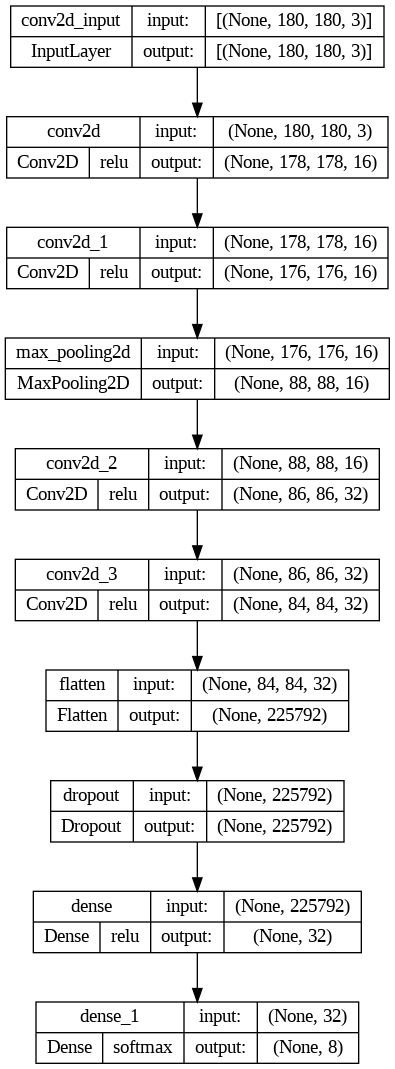

In [ ]:
plot_model(
    simple_cnn, 
    to_file='simple_cnn.png', 
    show_shapes=True, 
    show_layer_activations=True
)

**Fit the model and plot training history:**

In [ ]:
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].minorticks_on()
    ax[0].legend()
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].minorticks_on()
    ax[1].legend()
    plt.show()

In [ ]:
def fit_model(model, train_batches, val_batches, epochs=10):
    verbose = 2 if epochs <= 10 else 0
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=25,
        verbose=0,
        mode='max',
        restore_best_weights=True
    )

    history = model.fit(
        x=train_batches,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=verbose,
        steps_per_epoch=len(train_batches),
        validation_data=val_batches,
        validation_steps=len(val_batches)
    )
    print(f"Stopped training after {len(history.history['loss'])} epochs\n")
    plot_training_curve(history)

    return model, history

Stopped training after 33 epochs



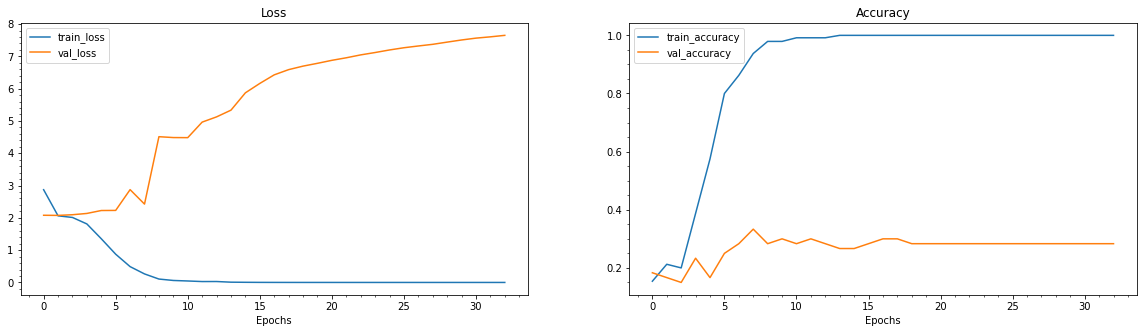

CPU times: user 1min 10s, sys: 1.64 s, total: 1min 11s
Wall time: 1min 9s


In [ ]:
%%time
simple_cnn, simple_cnn_history = fit_model(build_cnn(), train_batches, val_batches, epochs=100)

In [ ]:
def evaluate_model(model, val_batches, test_batches):
    val_score = model.evaluate(val_batches, verbose=0)
    print(f'---VALIDATION---\nloss = {val_score[0]:.4f}, accuracy = {val_score[1]*100:.2f}%')

    test_proba = model.predict(test_batches, verbose=0)
    test_preds = test_proba.argmax(axis=-1)
    test_preds_classes = [CLASSES[pred] for pred in test_preds]

    print('\n---TEST---')
    cm = ConfusionMatrixDisplay.from_predictions(test_df.target, test_preds_classes, cmap='Blues')
    cm.ax_.set_title('Confusion Matrix', fontsize=15, ha='center')
    cm.figure_.set_figheight(10)
    cm.figure_.set_figwidth(10)
    plt.xticks(rotation=30)
    plt.show()

    print('\nClassification Report:')
    print(classification_report(test_df.target, test_preds_classes))

---VALIDATION---
loss = 2.4257, accuracy = 33.33%

---TEST---


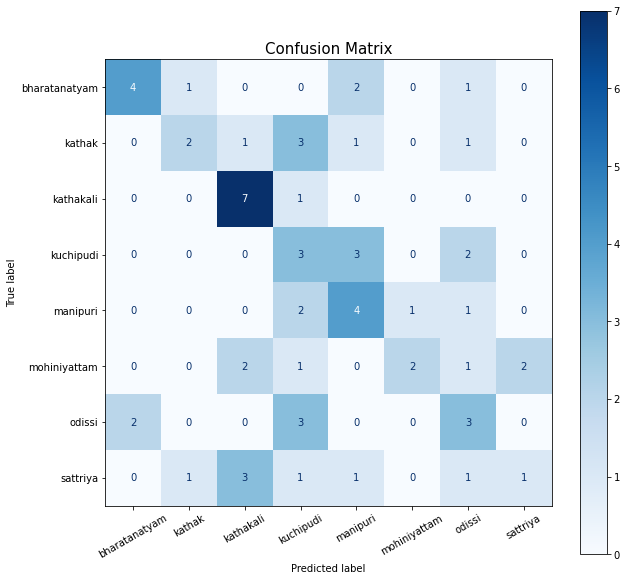


Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.67      0.50      0.57         8
       kathak       0.50      0.25      0.33         8
    kathakali       0.54      0.88      0.67         8
    kuchipudi       0.21      0.38      0.27         8
     manipuri       0.36      0.50      0.42         8
 mohiniyattam       0.67      0.25      0.36         8
       odissi       0.30      0.38      0.33         8
     sattriya       0.33      0.12      0.18         8

     accuracy                           0.41        64
    macro avg       0.45      0.41      0.39        64
 weighted avg       0.45      0.41      0.39        64



In [ ]:
evaluate_model(simple_cnn, val_batches, test_batches)

# CNN with Data Augmentation

In [ ]:
augment_args = {
    'rotation_range': 20, #degrees
    'shear_range': 0.05,
    'zoom_range': 0.1,
    'width_shift_range': 0.05,
    'height_shift_range': 0.05,
    'horizontal_flip': True
}

train_batches, val_batches, test_batches = build_data_pipeline(
    image_dir, train_df, test_df, augment_args
)

Found 240 validated image filenames belonging to 8 classes.
Found 60 validated image filenames belonging to 8 classes.
Found 64 validated image filenames.


Stopped training after 84 epochs



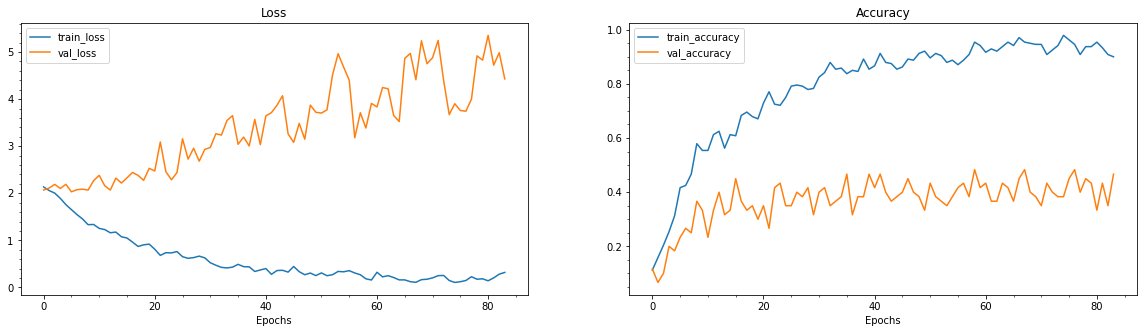

CPU times: user 5min 8s, sys: 2.5 s, total: 5min 11s
Wall time: 4min 50s


In [ ]:
%%time
aug_cnn = build_cnn() #same architecture as simple_cnn
aug_cnn, aug_cnn_history = fit_model(aug_cnn, train_batches, val_batches, epochs=100)

---VALIDATION---
loss = 4.0386, accuracy = 45.00%

---TEST---


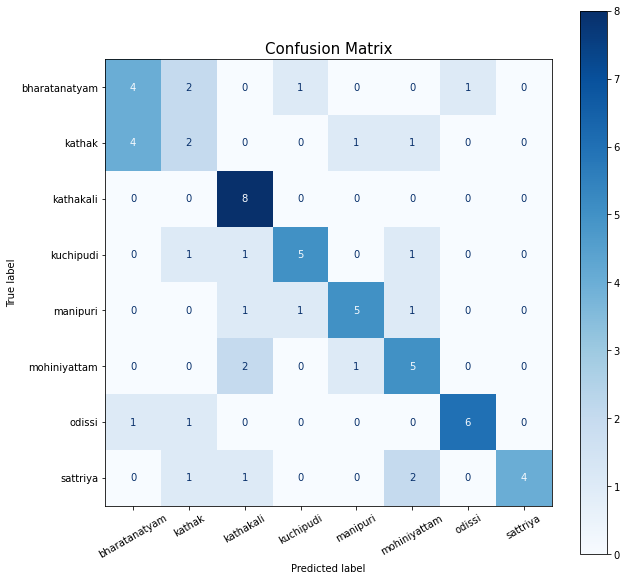


Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.44      0.50      0.47         8
       kathak       0.29      0.25      0.27         8
    kathakali       0.62      1.00      0.76         8
    kuchipudi       0.71      0.62      0.67         8
     manipuri       0.71      0.62      0.67         8
 mohiniyattam       0.50      0.62      0.56         8
       odissi       0.86      0.75      0.80         8
     sattriya       1.00      0.50      0.67         8

     accuracy                           0.61        64
    macro avg       0.64      0.61      0.61        64
 weighted avg       0.64      0.61      0.61        64



In [ ]:
evaluate_model(aug_cnn, val_batches, test_batches)

# Summary

* We trained a CNN from scratch in two modes: 
    * Mode 1: with original images
    * Mode 2: with data augmentation
* The primary limitation we face in the context of deep learning is that we have a very small amount of data. The original dataset has only 364 labelled images out which we separated 64 images to create a test dataset.
* As expected, Mode 1 did not show promising results with only 41% accuracy on the test set.
* Mode 2 showed the improvements we expected since we indirectly increase the size and variety of data by adding augmentations such as rotation, horizonal-flip, shear, shift and zoom.  
Performance improves to 61% accuracy on the test set.
* To tweak the performance, we tried several configurations manually. We can also tune the hyperparameters to find optimal configuration but it will not be able to overcome the primary limitation of limited data.
* Hence, we will directly move to a transfer learning approach. It is designed to work in situations with limited data and should be able to show further improvements.